In [14]:
import json
import os
import re
import sys
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from spellchecker import SpellChecker
import spacy
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from spacy.tokens import Doc
import logging
from itertools import chain
import string
from sklearn.metrics import classification_report, f1_score
import pandas as pd

In [3]:
#path of the json data
os.chdir('C:\\GitHub Repositories\\NLP-Detection-of-Negation-and-Uncertainty-Project-24\\Data')

In [4]:
# Loading the json file
loading = open("negacio_train_v2024.json")
training_data = json.load(loading)
print(len(training_data))

254


In [6]:
!python -m spacy download es_core_news_sm
!python -m spacy download ca_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 320.0 kB/s eta 0:00:41
     --------------------------------------- 0.1/12.9 MB 525.1 kB/s eta 0:00:25
      --------------------------------------- 0.3/12.9 MB 2.6 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.9 MB 3.5 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.9 MB 4.4 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.9 MB 4.9 MB/s eta 0:00:03
     ----- ---------------------------------- 1.6/12.9 MB 5.8 MB/s eta 0:00:02
     ------ --------------------------------- 2.1/12.9 MB 6.2 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.9 MB 6.7 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.9 MB 6.7 MB/s eta 0:00:02
     --------- ------------------------------ 3.2/12.9 MB 6.8 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.9 MB

In [7]:
# 1 Remove pacient information and redacted entries
def remove_pacient_info(text):
    # Remove lines starting with "nº historia clinica:" and ending with "motiu d'ingres"
    text = re.sub(r'nº historia clinica:.*?motiu d\'ingres', '', text, flags=re.DOTALL)
    # Remove lines starting with "nhc" and ending with "lopd"
    text = re.sub(r'nhc.*?lopd', '', text, flags=re.DOTALL)
    # Remove all asterisks '*'
    text = text.replace('*', '')
    return text


# 2 Remove Punctuation (Able to be turned ON/OFF)
def remove_punctuation(text):
    # Define a translation table to map punctuation to None
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuation using the translation table
    text = text.translate(translator)
    return text


# 3 Spell cheking with language detection (Able to be turned ON/OFF)
# Load language models for Spanish and Catalan
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

def lemmatize_text(text):
    # Detect the language of the text
    language = detect(text)

    # Tokenize the text using the appropriate language model
    if language == 'ca':
        doc = nlp_ca(text)
    else:
        doc = nlp_es(text)

    # Lemmatize tokens
    lemmatized_tokens = []
    for token in doc:
        # Check if the token is a punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # Lemmatize the token
            lemmatized_token = token.lemma_ if token.lemma_ != '-PRON-' else token.text
            lemmatized_tokens.append(lemmatized_token)
        else:
            lemmatized_tokens.append(token.text)

    # Join the tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


# 4 Tokenization with coordinates of the original text for (evaluation)
def tokenize_with_coordinates(text):
    # Tokenize the text while preserving the coordinates
    tokens_with_coordinates = []
    token_start = 0
    for token in re.finditer(r'\S+', text):
        token_text = token.group(0)
        token_end = token_start + len(token_text)
        tokens_with_coordinates.append((token_text, token_start, token_end))
        # Update token start position for the next token
        token_start = token_end
    return tokens_with_coordinates


# Main function to process the text
def pre_process_text(text, remove_punctuation_call=True, spell_check_call=True):

    # 1 Remove pacient information and redacted entries
    preprocessed_text = remove_pacient_info(text)

    # 2 Remove punctuation if specified
    if remove_punctuation_call:
        preprocessed_text = remove_punctuation(preprocessed_text)

    # 3 Spell check and lemmatize if specified
    if spell_check_call:
        preprocessed_text = lemmatize_text(preprocessed_text)

    # 4 Tokenize the text with coordinates
    tokens_with_coordinates = tokenize_with_coordinates(preprocessed_text)

    return tokens_with_coordinates

## <span style="color:red; font-size:larger;">**DATA ANNOTATION**</span>


In [8]:
def strip_tokens(tagged_text):
    def find_indices(tokens, start_token, end_token, occurrence=1):
        start_index = None
        end_index = None
        end_token_count = 0
        for i, (word, _, _) in enumerate(tokens):
            if word == start_token and start_index is None:
                start_index = i
            if word == end_token:
                end_token_count += 1
                if end_token_count == occurrence:
                    end_index = i
                    break
        return start_index, end_index

    # Remove sections from "nº" to the second occurrence of "d'ingres"
    start1, end1 = find_indices(tagged_text, 'nº', "d'ingres", occurrence=2)
    if end1 is not None:
        end1 += 1  # Include the end token

    # If the indices are found, remove the section
    new_tagged_text = []
    if start1 is not None and end1 is not None:
        new_tagged_text = tagged_text[:start1] + tagged_text[end1:]
    else:
        new_tagged_text = tagged_text[:]

    # Continuously find and remove all sections from "nhc" to "lopd"
    while True:
        start2, end2 = find_indices(new_tagged_text, 'nhc', 'lopd')
        if start2 is not None and end2 is not None:
            end2 += 1  # Include the end token
            new_tagged_text = new_tagged_text[:start2] + new_tagged_text[end2:]
        else:
            break

    return new_tagged_text

def tag_words_from_json(json_data):
    # Initialize lists for all tagged texts and counts
    all_tagged_texts = []
    all_counts = []

    # Iterate through each entry in the JSON data
    for entry in json_data:
        # Extract text and predictions from JSON entry
        text = entry['data']['text']
        predictions = entry['predictions'][0]['result']

        # Initialize counters
        counts = {'NEG': 0, 'NSCO': 0, 'UNC': 0, 'USCO': 0}

        # Initialize tokens and their coordinates
        tokens = []
        start_pos = 0

        # Split text into tokens while tracking their start and end positions
        for word in text.split():
            start = text.find(word, start_pos)
            end = start + len(word)
            tokens.append((word, start, end))
            start_pos = end

        # Initialize tags list
        tags = ['O'] * len(tokens)

        # Tag each word
        for pred in predictions:
            pred_start = pred['value']['start']
            pred_end = pred['value']['end']
            label = pred['value']['labels'][0]

            if label in counts:
                counts[label] += 1
                for i, (word, start, end) in enumerate(tokens):
                    if start < pred_end and end > pred_start:
                        tags[i] = label

        # Combine tokens with tags
        tagged_text = [(token[0], (token[1], token[2]), tags[i]) for i, token in enumerate(tokens)]

        # Strip unwanted tokens
        stripped_tagged_text = strip_tokens(tagged_text)

        # Append the results to the lists
        all_tagged_texts.append(stripped_tagged_text)
        all_counts.append(counts)

    # Return the list of tagged words and counts for all entries
    return all_tagged_texts,all_counts

## <span style="color:red; font-size:larger;">**FEATURE EXTRACTION FUNCTIONS**</span>


In [9]:
# Spacy models for preprocessing in catalan or spanish
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

#list of negation special words feature
special_words = {"nada", "ni", "nunca", "ningun", "ninguno", "ninguna", "alguna", "apenas", "para nada", "ni siquiera"}

# feature extractor function
def word2features(doc, i, sentence_index):
    word = doc[i].text

    features = {
        'WORD': word,                                                       # TOKEN
        'POS': doc[i].pos_,                                                 # PART-OF-SPEECH OF THE TOKEN                
        'INIT_CAP': word[0].isupper(),                                      # TOKEN BEGGINS WITH UPPERCASE LETTER
        'ALPHANUM': word.isalnum(),                                         # TOKEN IS A NUMBER
        'HAS_NUM': any(char.isdigit() for char in word),                    # TOKEN CONTAINS A NUMBER
        'HAS_CAP': any(char.isupper() for char in word),                    # TOKEN CONTAINS A NUMBER
        'HAS_DASH': '-' in word,                                            # TOKEN CONTAINS A DASH
        'HAS_US': '_' in word,                                              # TOKEN CONTAINS AN UNDERSCORE
        'PUNCTUATION': any(char in string.punctuation for char in word),    # TOKEN CONTAINS PUNCTUATION
        'SUF2': word[-2:] if len(word) > 1 else '',                         # LAST TWO LETTERS
        'SUF3': word[-3:] if len(word) > 2 else '',                         # LAST THREE LETTERS    
        'SUF4': word[-4:] if len(word) > 3 else '',                         # LAST FOUR LETTERS
        'PREF2': word[:2] if len(word) > 1 else '',                         # FIRST TWO LETTERS
        'PREF3': word[:3] if len(word) > 2 else '',                         # FIRST THREE LETTERS    
        'PREF4': word[:4] if len(word) > 3 else '',                         # FIRST FOUR LETTERS
        'SPECIAL': word in special_words                                    # IS ONE OF THE SPECIAL WORDS
    }

    if i > 0:
        features.update({
            '2GRAMBEFORE': ' '.join([doc[i-1].text, word]),                 # BIGRAM OF THE TOKEN AND THE PREVIOUS ONE
            'BEFOREPOS': doc[i-1].pos_,                                  # POS OF THE TOKEN AND THE PREVIOUS ONE
            'BEFOREPOS': doc[i-1].pos_
        })
    else:
        features['BOS'] = True  # Mark beginning of sentence

    if i < len(doc) - 1:
        features.update({
            '2GRAMAFTER': ' '.join([word, doc[i+1].text]),                  # BIGRAM OF THE TOKEN AND THE NEXT ONE
            'AFTERPOS': doc[i+1].pos_                                       # POS OF THE TOKEN AND THE NEXT ONE
        })
    else:
        features['EOS'] = True  # Mark end of sentence

    return features

# send text to features
def sent2features(sent, lang='es', sentence_index=0):
    nlp = nlp_ca if lang == 'ca' else nlp_es
    words = [word[0] for word in sent]  # Extract the words from the sent
    spaces = [True] * (len(words) - 1) + [False]  # Space after each word except the last

    # create a doc from words and spaces to have the same output and input lenght
    doc = Doc(nlp.vocab, words=words, spaces=spaces)
    
    features = []
    for i in range(len(doc)):
        f = word2features(doc, i, sentence_index) # send the current doc (text) to the feature extractor
        if f is not None:
            features.append(f) #append features extracted to a list 
    return features


# preprocessing step function 
def prepare_data_for_crf(json_data):
    tagged_texts, counts = tag_words_from_json(json_data)
    all_features = []
    all_labels = []
    for idx, text in enumerate(tagged_texts): #iterate over the the texts
    
        features = sent2features(text, detect_language(text), idx) #sends a text to sent2features
        labels = [token[2] for token in text]
        all_features.append(features)
        all_labels.append(labels)

    return all_features, all_labels

def detect_language(text):
    return 'es'  # 'es' or 'ca' based on your detection logic

## <span style="color:red; font-size:larger;">**MODEL**</span>


In [10]:
# Prepare features and labels with preprocessing function
X_train_full, y_train_full = prepare_data_for_crf(training_data) 

# data splitting for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

## <span style="color:red; font-size:larger;">**MODEL EVALUATION**</span>

**FIRST VALIDATION FUNCTION**

In [11]:
#function to plot the confusion matrix with seaborn
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 88.14it/s]

Training fold 1/5...


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 90.16it/s] 

Fold 1, Iteration 1/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 117.00it/s]

Fold 1, Iteration 2/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 118.98it/s]

Fold 1, Iteration 3/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.70it/s]

Fold 1, Iteration 4/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 92.35it/s] 

Fold 1, Iteration 5/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:01, 99.79it/s]

Fold 1, Iteration 6/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 90.59it/s] 

Fold 1, Iteration 7/20: Validation Accuracy = 0.9030284144026743


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.66it/s]

Fold 1, Iteration 8/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 90.99it/s] 

Fold 1, Iteration 9/20: Validation Accuracy = 0.8963710020113884


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 104.80it/s]

Fold 1, Iteration 10/20: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 118.81it/s]

Fold 1, Iteration 11/20: Validation Accuracy = 0.9150117567069889


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:01, 97.41it/s]

Fold 1, Iteration 12/20: Validation Accuracy = 0.9126037564803535


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 93.76it/s] 

Fold 1, Iteration 13/20: Validation Accuracy = 0.9300546757698518


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.65it/s]

Fold 1, Iteration 14/20: Validation Accuracy = 0.9279582991019576


loading training data to CRFsuite:   8%|▊         | 17/203 [00:00<00:02, 72.29it/s]

Fold 1, Iteration 15/20: Validation Accuracy = 0.9322077112666082


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 97.44it/s]

Fold 1, Iteration 16/20: Validation Accuracy = 0.9322077112666082


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 84.13it/s]

Fold 1, Iteration 17/20: Validation Accuracy = 0.9396583472619621


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 92.88it/s]

Fold 1, Iteration 18/20: Validation Accuracy = 0.9414714297855463


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:01, 99.83it/s]

Fold 1, Iteration 19/20: Validation Accuracy = 0.9416130768577013


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 86.91it/s]


Fold 1, Iteration 20/20: Validation Accuracy = 0.9435394770390096


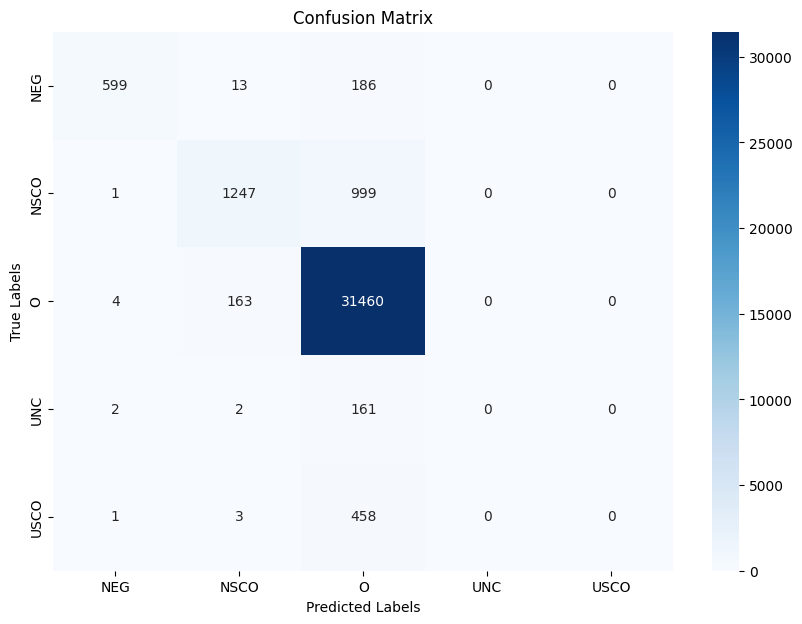

loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.57it/s]

Training fold 2/5...


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 107.77it/s]

Fold 2, Iteration 1/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 109.95it/s]

Fold 2, Iteration 2/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 109.88it/s]

Fold 2, Iteration 3/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 106.99it/s]

Fold 2, Iteration 4/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 107.40it/s]

Fold 2, Iteration 5/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 109.41it/s]

Fold 2, Iteration 6/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 108.59it/s]

Fold 2, Iteration 7/20: Validation Accuracy = 0.8909415781245015


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 106.53it/s]

Fold 2, Iteration 8/20: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 107.50it/s]

Fold 2, Iteration 9/20: Validation Accuracy = 0.8998117481892728


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 106.22it/s]

Fold 2, Iteration 10/20: Validation Accuracy = 0.9097986662837816


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.88it/s]

Fold 2, Iteration 11/20: Validation Accuracy = 0.9317507418397626


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 106.67it/s]

Fold 2, Iteration 12/20: Validation Accuracy = 0.9321336268785297


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 106.43it/s]

Fold 2, Iteration 13/20: Validation Accuracy = 0.9392489071822852


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:02, 95.54it/s]

Fold 2, Iteration 14/20: Validation Accuracy = 0.9402380268657669


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:03, 55.98it/s]

Fold 2, Iteration 15/20: Validation Accuracy = 0.9427267796177531


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 106.17it/s]

Fold 2, Iteration 16/20: Validation Accuracy = 0.9408123544239175


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 115.12it/s]

Fold 2, Iteration 17/20: Validation Accuracy = 0.9403337481254587


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 111.08it/s]

Fold 2, Iteration 18/20: Validation Accuracy = 0.940620911904534


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 105.93it/s]

Fold 2, Iteration 19/20: Validation Accuracy = 0.9416100315880157


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 85.68it/s]


Fold 2, Iteration 20/20: Validation Accuracy = 0.9438754347340544


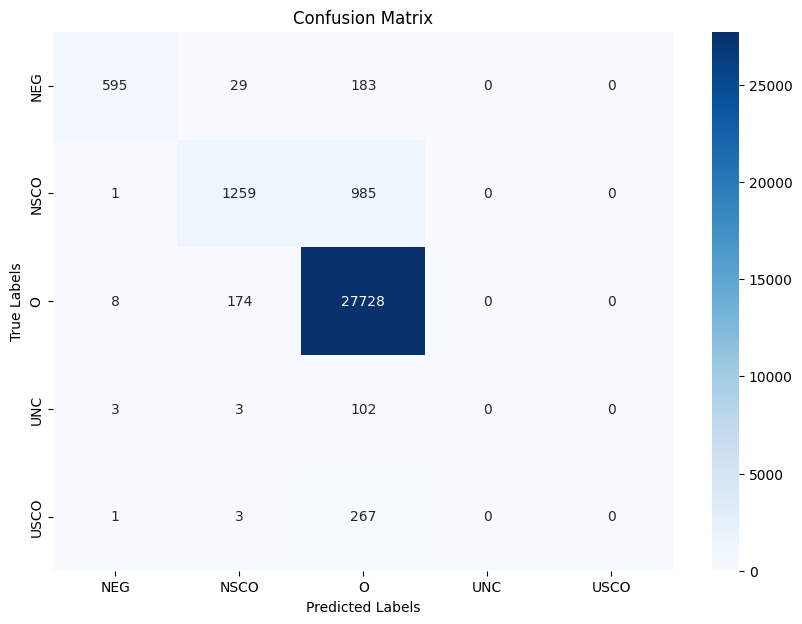

loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 100.38it/s]

Training fold 3/5...


loading training data to CRFsuite:   4%|▍         | 9/203 [00:00<00:02, 89.74it/s]

Fold 3, Iteration 1/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.11it/s]

Fold 3, Iteration 2/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 97.76it/s]

Fold 3, Iteration 3/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.39it/s]

Fold 3, Iteration 4/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 101.76it/s]

Fold 3, Iteration 5/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.02it/s]

Fold 3, Iteration 6/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 102.60it/s]

Fold 3, Iteration 7/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 97.32it/s]

Fold 3, Iteration 8/20: Validation Accuracy = 0.8849229997177179


loading training data to CRFsuite:   4%|▍         | 9/203 [00:00<00:02, 89.89it/s]

Fold 3, Iteration 9/20: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:01, 99.94it/s]

Fold 3, Iteration 10/20: Validation Accuracy = 0.9017658313207666


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 98.82it/s]

Fold 3, Iteration 11/20: Validation Accuracy = 0.8888435843552991


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:02, 93.74it/s]

Fold 3, Iteration 12/20: Validation Accuracy = 0.9103283881692438


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:01, 99.74it/s]

Fold 3, Iteration 13/20: Validation Accuracy = 0.9060627920835554


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 100.68it/s]

Fold 3, Iteration 14/20: Validation Accuracy = 0.9258852680111658


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.38it/s]

Fold 3, Iteration 15/20: Validation Accuracy = 0.9239092933538249


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 101.41it/s]

Fold 3, Iteration 16/20: Validation Accuracy = 0.9318131919831886


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.47it/s]

Fold 3, Iteration 17/20: Validation Accuracy = 0.9324091208481009


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.16it/s]

Fold 3, Iteration 18/20: Validation Accuracy = 0.9346673775993476


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 101.48it/s]

Fold 3, Iteration 19/20: Validation Accuracy = 0.93767838660101


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 87.68it/s] 


Fold 3, Iteration 20/20: Validation Accuracy = 0.9374588338613054


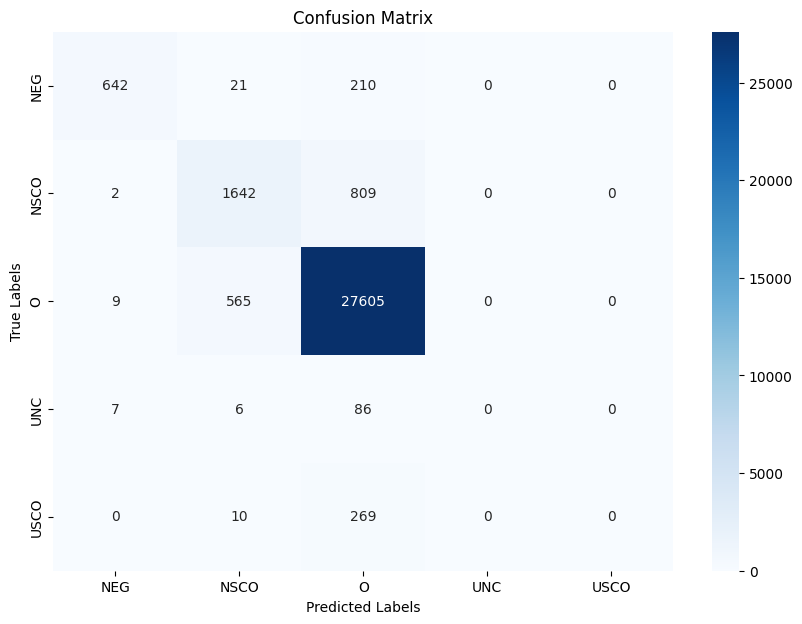

loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 90.11it/s]

Training fold 4/5...


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.14it/s] 

Fold 4, Iteration 1/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 115.55it/s]

Fold 4, Iteration 2/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 98.20it/s] 

Fold 4, Iteration 3/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 96.37it/s] 

Fold 4, Iteration 4/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 96.02it/s] 

Fold 4, Iteration 5/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 91.53it/s] 

Fold 4, Iteration 6/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 98.42it/s] 

Fold 4, Iteration 7/20: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 117.85it/s]

Fold 4, Iteration 8/20: Validation Accuracy = 0.8704090695365968


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 93.90it/s] 

Fold 4, Iteration 9/20: Validation Accuracy = 0.8699127527297424


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 115.35it/s]

Fold 4, Iteration 10/20: Validation Accuracy = 0.905072880204796


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 97.54it/s] 

Fold 4, Iteration 11/20: Validation Accuracy = 0.9012329554359751


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.87it/s] 

Fold 4, Iteration 12/20: Validation Accuracy = 0.9251084060393919


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 92.72it/s] 

Fold 4, Iteration 13/20: Validation Accuracy = 0.9251867718510005


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 116.77it/s]

Fold 4, Iteration 14/20: Validation Accuracy = 0.9280340630061126


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 94.71it/s] 

Fold 4, Iteration 15/20: Validation Accuracy = 0.9285303798129669


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 116.78it/s]

Fold 4, Iteration 16/20: Validation Accuracy = 0.9328143775142365


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.07it/s]

Fold 4, Iteration 17/20: Validation Accuracy = 0.9342772059975968


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 116.66it/s]

Fold 4, Iteration 18/20: Validation Accuracy = 0.9364975706598402


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 116.67it/s]

Fold 4, Iteration 19/20: Validation Accuracy = 0.9395538373125751


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 91.60it/s] 


Fold 4, Iteration 20/20: Validation Accuracy = 0.9410166657959355


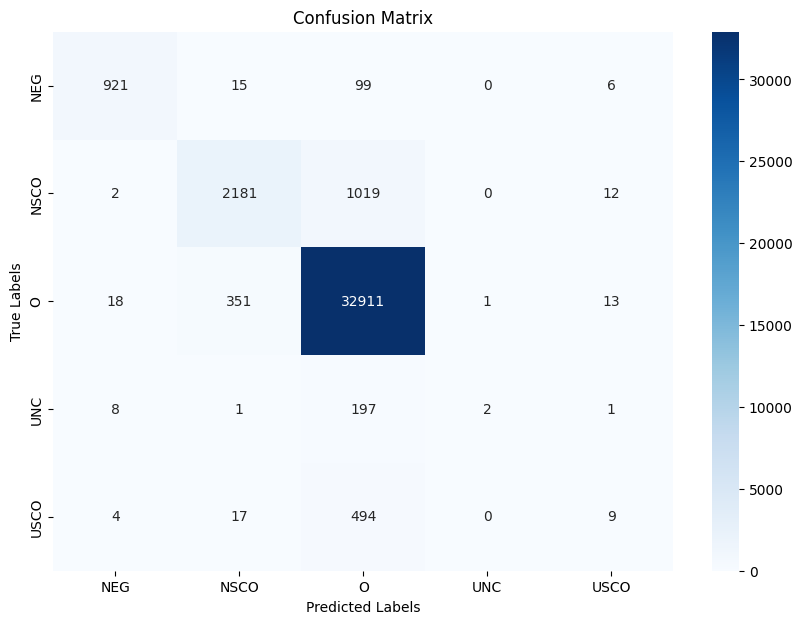

loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 101.55it/s]

Training fold 5/5...


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 102.01it/s]

Fold 5, Iteration 1/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 111.92it/s]

Fold 5, Iteration 2/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 112.57it/s]

Fold 5, Iteration 3/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 110.66it/s]

Fold 5, Iteration 4/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 98.84it/s]

Fold 5, Iteration 5/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 106.44it/s]

Fold 5, Iteration 6/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 114.34it/s]

Fold 5, Iteration 7/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 111.61it/s]

Fold 5, Iteration 8/20: Validation Accuracy = 0.8873823327722711


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 113.31it/s]

Fold 5, Iteration 9/20: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 106.63it/s]

Fold 5, Iteration 10/20: Validation Accuracy = 0.9010660183280345


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 112.73it/s]

Fold 5, Iteration 11/20: Validation Accuracy = 0.8905928558069945


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 113.18it/s]

Fold 5, Iteration 12/20: Validation Accuracy = 0.9097313135091328


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 107.17it/s]

Fold 5, Iteration 13/20: Validation Accuracy = 0.9057415373106414


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 107.17it/s]

Fold 5, Iteration 14/20: Validation Accuracy = 0.922666916027679


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 93.72it/s] 

Fold 5, Iteration 15/20: Validation Accuracy = 0.9219500031170127


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 107.18it/s]

Fold 5, Iteration 16/20: Validation Accuracy = 0.9284022193130104


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 104.29it/s]

Fold 5, Iteration 17/20: Validation Accuracy = 0.9307399788043139


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 105.21it/s]

Fold 5, Iteration 18/20: Validation Accuracy = 0.9323296552584004


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 113.27it/s]

Fold 5, Iteration 19/20: Validation Accuracy = 0.9377844274047753


loading training data to CRFsuite: 100%|██████████| 204/204 [00:02<00:00, 89.15it/s] 


Fold 5, Iteration 20/20: Validation Accuracy = 0.9340751823452403


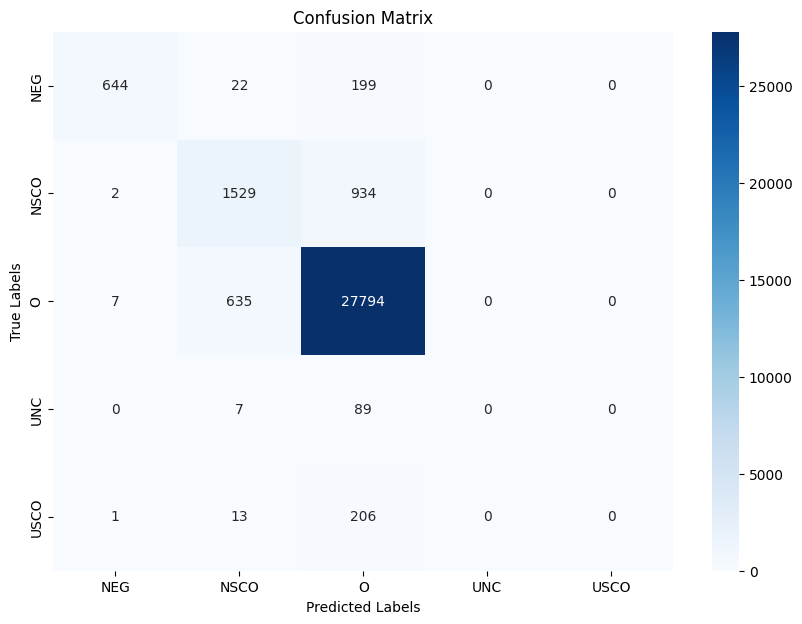

In [13]:
def capture_loss_from_log(log_contents):
    loss_values = [float(match.group(1)) for match in re.finditer(r'loss=(\d+\.\d+)', log_contents)]
    return loss_values

def train_crf_with_cross_validation(X, y, k_folds=5, max_iterations=50):

    # make 5 folds
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_loss_values = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}/{k_folds}...")  # Debug print
        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in val_index]
        y_val = [y[i] for i in val_index]

        crf = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=1,  # We'll manually control the iterations
            all_possible_transitions=True,
            verbose=True #parameter to capture training information
        )

        val_accuracies = []
        iteration_loss_values = []

        for i in range(1, max_iterations + 1):
            # Capture the log output
            log_stream = StringIO()
            original_stdout = sys.stdout
            sys.stdout = log_stream

            try:
                # Set the number of iterations
                crf.max_iterations = i

                # Fit the model
                crf.fit(X_train, y_train)

            finally:
                sys.stdout = original_stdout

            # Extract loss values
            log_contents = log_stream.getvalue()
            loss_values = capture_loss_from_log(log_contents)
            if loss_values:
                iteration_loss_values.append(loss_values[-1])

            # Evaluate on the validation set
            val_predictions = crf.predict(X_val)
            y_val_flat = list(chain.from_iterable(y_val))
            val_predictions_flat = list(chain.from_iterable(val_predictions))
            val_accuracy = accuracy_score(y_val_flat, val_predictions_flat)

            # Store validation accuracy
            val_accuracies.append(val_accuracy)

            # Print progress
            print(f"Fold {fold + 1}, Iteration {i}/{max_iterations}: Validation Accuracy = {val_accuracy}")

            # Plot confusion matrix for the last iteration of the fold
            if i == max_iterations:
                unique_labels = sorted(set(y_val_flat))
                plot_confusion_matrix(y_val_flat, val_predictions_flat, unique_labels)

        fold_accuracies.append(val_accuracies)
        fold_loss_values.append(iteration_loss_values)

    return fold_accuracies, fold_loss_values

# Perform k-fold cross-validation with validation accuracy and loss tracking
k_folds = 5
max_iterations = 20
fold_accuracies, fold_loss_values = train_crf_with_cross_validation(X_train_full, y_train_full, k_folds, max_iterations)


**SECOND VALIDATION FUNCTION WITH TUNNED PARAMETERS**

loading training data to CRFsuite:   4%|▍         | 9/203 [00:00<00:02, 87.78it/s]

Training fold 1/5...


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 103.44it/s]

Fold 1, Iteration 1/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 115.88it/s]

Fold 1, Iteration 2/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.78it/s]

Fold 1, Iteration 3/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 112.27it/s]

Fold 1, Iteration 4/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 103.18it/s]

Fold 1, Iteration 5/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 94.07it/s]

Fold 1, Iteration 6/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 86.95it/s]

Fold 1, Iteration 7/50: Validation Accuracy = 0.9033683673758464


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 81.06it/s] 

Fold 1, Iteration 8/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 79.92it/s] 

Fold 1, Iteration 9/50: Validation Accuracy = 0.8963710020113884


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 76.86it/s]

Fold 1, Iteration 10/50: Validation Accuracy = 0.8959743902093543


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 83.03it/s] 

Fold 1, Iteration 11/50: Validation Accuracy = 0.9149267684636958


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 101.32it/s]

Fold 1, Iteration 12/50: Validation Accuracy = 0.9126037564803535


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 104.59it/s]

Fold 1, Iteration 13/50: Validation Accuracy = 0.9300546757698518


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 113.74it/s]

Fold 1, Iteration 14/50: Validation Accuracy = 0.9280432873452505


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 111.27it/s]

Fold 1, Iteration 15/50: Validation Accuracy = 0.9323210289243321


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 95.01it/s] 

Fold 1, Iteration 16/50: Validation Accuracy = 0.9325476642397802


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 87.69it/s] 

Fold 1, Iteration 17/50: Validation Accuracy = 0.9398283237485481


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 92.44it/s] 

Fold 1, Iteration 18/50: Validation Accuracy = 0.9414714297855463


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 110.26it/s]

Fold 1, Iteration 19/50: Validation Accuracy = 0.9415847474432704


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 129.78it/s]

Fold 1, Iteration 20/50: Validation Accuracy = 0.9435961358678716


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 128.75it/s]

Fold 1, Iteration 21/50: Validation Accuracy = 0.9416980651009944


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 86.70it/s] 

Fold 1, Iteration 22/50: Validation Accuracy = 0.9499985835292785


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 92.95it/s]

Fold 1, Iteration 23/50: Validation Accuracy = 0.9509051247910706


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 106.53it/s]

Fold 1, Iteration 24/50: Validation Accuracy = 0.9462591008243859


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 96.01it/s]

Fold 1, Iteration 25/50: Validation Accuracy = 0.9525765602424998


loading training data to CRFsuite:   9%|▉         | 18/203 [00:00<00:02, 86.05it/s]

Fold 1, Iteration 26/50: Validation Accuracy = 0.9537380662341709


loading training data to CRFsuite:   4%|▍         | 8/203 [00:00<00:02, 76.57it/s]

Fold 1, Iteration 27/50: Validation Accuracy = 0.9563160429473923


loading training data to CRFsuite:   7%|▋         | 14/203 [00:00<00:03, 55.21it/s]

Fold 1, Iteration 28/50: Validation Accuracy = 0.9565993370917023


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 83.56it/s] 

Fold 1, Iteration 29/50: Validation Accuracy = 0.9568826312360124


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 82.83it/s] 

Fold 1, Iteration 30/50: Validation Accuracy = 0.9591489843904927


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 84.55it/s] 

Fold 1, Iteration 31/50: Validation Accuracy = 0.9601121844811468


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 86.98it/s] 

Fold 1, Iteration 32/50: Validation Accuracy = 0.9591489843904927


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 109.00it/s]

Fold 1, Iteration 33/50: Validation Accuracy = 0.9607920904274909


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:02, 73.69it/s] 

Fold 1, Iteration 34/50: Validation Accuracy = 0.961415337544973


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 82.59it/s]

Fold 1, Iteration 35/50: Validation Accuracy = 0.962265219977903


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:02, 94.96it/s]

Fold 1, Iteration 36/50: Validation Accuracy = 0.9638799966004703


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 112.01it/s]

Fold 1, Iteration 37/50: Validation Accuracy = 0.9637383495283153


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 86.68it/s] 

Fold 1, Iteration 38/50: Validation Accuracy = 0.9595739256069578


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 118.94it/s]

Fold 1, Iteration 39/50: Validation Accuracy = 0.96161364344599


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 118.58it/s]

Fold 1, Iteration 40/50: Validation Accuracy = 0.9615003257882659


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 85.09it/s]

Fold 1, Iteration 41/50: Validation Accuracy = 0.9632567494829882


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 86.05it/s] 

Fold 1, Iteration 42/50: Validation Accuracy = 0.961103713986232


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 114.04it/s]

Fold 1, Iteration 43/50: Validation Accuracy = 0.9594322785348027


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 87.75it/s] 

Fold 1, Iteration 44/50: Validation Accuracy = 0.9607071021841979


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 115.36it/s]

Fold 1, Iteration 45/50: Validation Accuracy = 0.9579308195699595


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 113.56it/s]

Fold 1, Iteration 46/50: Validation Accuracy = 0.9584690784441485


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 83.64it/s] 

Fold 1, Iteration 47/50: Validation Accuracy = 0.9569109606504433


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 116.90it/s]

Fold 1, Iteration 48/50: Validation Accuracy = 0.9583557607864246


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 86.73it/s] 

Fold 1, Iteration 49/50: Validation Accuracy = 0.9572792430380465


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 88.65it/s] 


Fold 1, Iteration 50/50: Validation Accuracy = 0.9591773138049237


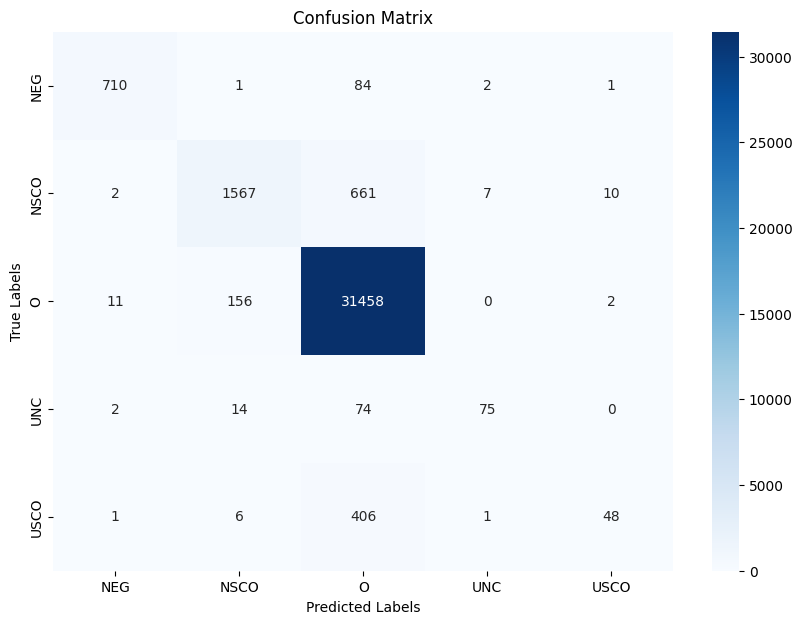

loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.66it/s]

Training fold 2/5...


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 103.32it/s]

Fold 2, Iteration 1/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 112.04it/s]

Fold 2, Iteration 2/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 102.91it/s]

Fold 2, Iteration 3/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 115.73it/s]

Fold 2, Iteration 4/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 106.57it/s]

Fold 2, Iteration 5/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 107.75it/s]

Fold 2, Iteration 6/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 102.93it/s]

Fold 2, Iteration 7/50: Validation Accuracy = 0.8909415781245015


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 111.96it/s]

Fold 2, Iteration 8/50: Validation Accuracy = 0.8905267859991705


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 105.19it/s]

Fold 2, Iteration 9/50: Validation Accuracy = 0.8998117481892728


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 115.93it/s]

Fold 2, Iteration 10/50: Validation Accuracy = 0.9098624804569094


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 99.10it/s] 

Fold 2, Iteration 11/50: Validation Accuracy = 0.9320059985322741


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 105.66it/s]

Fold 2, Iteration 12/50: Validation Accuracy = 0.9322293481382214


loading training data to CRFsuite:   8%|▊         | 16/203 [00:00<00:02, 69.05it/s]

Fold 2, Iteration 13/50: Validation Accuracy = 0.9392489071822852


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:01, 92.24it/s]

Fold 2, Iteration 14/50: Validation Accuracy = 0.9392808142688491


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.99it/s]

Fold 2, Iteration 15/50: Validation Accuracy = 0.9427586867043171


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 104.42it/s]

Fold 2, Iteration 16/50: Validation Accuracy = 0.9407804473373537


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 102.88it/s]

Fold 2, Iteration 17/50: Validation Accuracy = 0.9407804473373537


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 106.08it/s]

Fold 2, Iteration 18/50: Validation Accuracy = 0.9405251906448422


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 100.19it/s]

Fold 2, Iteration 19/50: Validation Accuracy = 0.9412590536358125


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 117.48it/s]

Fold 2, Iteration 20/50: Validation Accuracy = 0.9436839922146709


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 99.34it/s] 

Fold 2, Iteration 21/50: Validation Accuracy = 0.9473214000829584


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 108.79it/s]

Fold 2, Iteration 22/50: Validation Accuracy = 0.9491081969305383


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 107.20it/s]

Fold 2, Iteration 23/50: Validation Accuracy = 0.9523627197600587


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 104.43it/s]

Fold 2, Iteration 24/50: Validation Accuracy = 0.9539899811748189


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 102.76it/s]

Fold 2, Iteration 25/50: Validation Accuracy = 0.9577231103027982


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 102.37it/s]

Fold 2, Iteration 26/50: Validation Accuracy = 0.9575316677834147


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 105.78it/s]

Fold 2, Iteration 27/50: Validation Accuracy = 0.9592546504578667


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 112.08it/s]

Fold 2, Iteration 28/50: Validation Accuracy = 0.961679589036725


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 108.49it/s]

Fold 2, Iteration 29/50: Validation Accuracy = 0.9627325228933347


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 108.34it/s]

Fold 2, Iteration 30/50: Validation Accuracy = 0.9630196866724099


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 112.59it/s]

Fold 2, Iteration 31/50: Validation Accuracy = 0.9653169969050126


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 102.42it/s]

Fold 2, Iteration 32/50: Validation Accuracy = 0.9669123512332088


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 105.66it/s]

Fold 2, Iteration 33/50: Validation Accuracy = 0.9671357008391563


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 106.12it/s]

Fold 2, Iteration 34/50: Validation Accuracy = 0.9697520819373983


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.83it/s]

Fold 2, Iteration 35/50: Validation Accuracy = 0.9692415685523755


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.52it/s]

Fold 2, Iteration 36/50: Validation Accuracy = 0.9702625953224211


loading training data to CRFsuite:   6%|▋         | 13/203 [00:00<00:01, 115.87it/s]

Fold 2, Iteration 37/50: Validation Accuracy = 0.9684438913882774


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 105.25it/s]

Fold 2, Iteration 38/50: Validation Accuracy = 0.9688267764270444


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 106.57it/s]

Fold 2, Iteration 39/50: Validation Accuracy = 0.96732714335854


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 106.40it/s]

Fold 2, Iteration 40/50: Validation Accuracy = 0.9678376567435627


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 100.23it/s]

Fold 2, Iteration 41/50: Validation Accuracy = 0.9658913244631633


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 105.27it/s]

Fold 2, Iteration 42/50: Validation Accuracy = 0.9652531827318848


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 102.07it/s]

Fold 2, Iteration 43/50: Validation Accuracy = 0.9659232315497271


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 110.28it/s]

Fold 2, Iteration 44/50: Validation Accuracy = 0.9641045276155834


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 108.48it/s]

Fold 2, Iteration 45/50: Validation Accuracy = 0.9627006158067707


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 105.44it/s]

Fold 2, Iteration 46/50: Validation Accuracy = 0.9635302000574327


loading training data to CRFsuite:  13%|█▎        | 26/203 [00:00<00:01, 107.21it/s]

Fold 2, Iteration 47/50: Validation Accuracy = 0.9623815449411314


loading training data to CRFsuite:  12%|█▏        | 25/203 [00:00<00:01, 105.02it/s]

Fold 2, Iteration 48/50: Validation Accuracy = 0.9654446252512683


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 110.03it/s]

Fold 2, Iteration 49/50: Validation Accuracy = 0.9648702976931176


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 85.05it/s] 


Fold 2, Iteration 50/50: Validation Accuracy = 0.9654765323378323


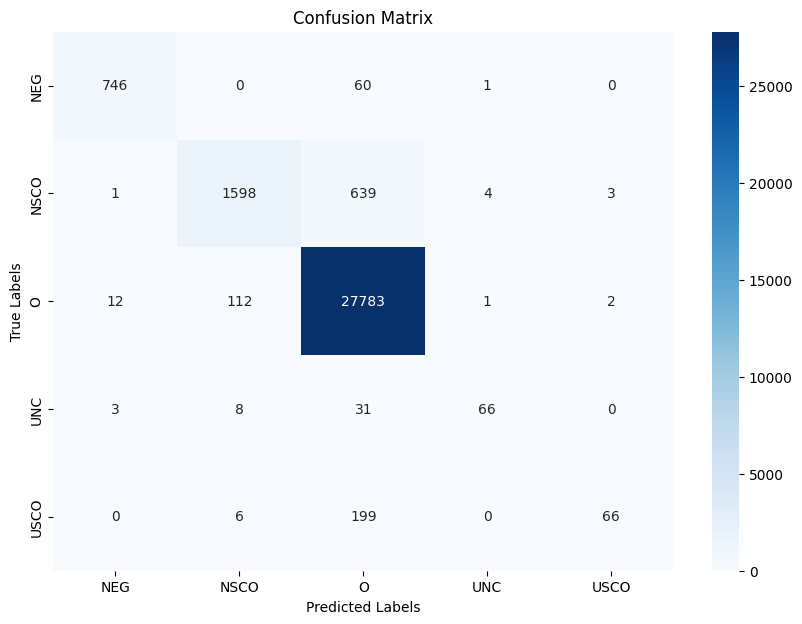

loading training data to CRFsuite:   9%|▉         | 18/203 [00:00<00:02, 88.28it/s]

Training fold 3/5...


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 94.61it/s]

Fold 3, Iteration 1/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 102.34it/s]

Fold 3, Iteration 2/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 107.82it/s]

Fold 3, Iteration 3/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.76it/s]

Fold 3, Iteration 4/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 101.81it/s]

Fold 3, Iteration 5/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 108.65it/s]

Fold 3, Iteration 6/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.53it/s]

Fold 3, Iteration 7/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 109.40it/s]

Fold 3, Iteration 8/50: Validation Accuracy = 0.8849229997177179


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.96it/s]

Fold 3, Iteration 9/50: Validation Accuracy = 0.8838252360191952


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 99.66it/s] 

Fold 3, Iteration 10/50: Validation Accuracy = 0.9020481134146724


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 106.83it/s]

Fold 3, Iteration 11/50: Validation Accuracy = 0.8888435843552991


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 100.64it/s]

Fold 3, Iteration 12/50: Validation Accuracy = 0.9104538468776464


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 90.21it/s]

Fold 3, Iteration 13/50: Validation Accuracy = 0.9064391682087632


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 101.84it/s]

Fold 3, Iteration 14/50: Validation Accuracy = 0.9258852680111658


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.14it/s]

Fold 3, Iteration 15/50: Validation Accuracy = 0.9239406580309256


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.29it/s]

Fold 3, Iteration 16/50: Validation Accuracy = 0.9318131919831886


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.41it/s]

Fold 3, Iteration 17/50: Validation Accuracy = 0.9322522974625976


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 102.23it/s]

Fold 3, Iteration 18/50: Validation Accuracy = 0.934730106953549


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 106.98it/s]

Fold 3, Iteration 19/50: Validation Accuracy = 0.9376156572468086


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 104.61it/s]

Fold 3, Iteration 20/50: Validation Accuracy = 0.9373961045071041


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.05it/s]

Fold 3, Iteration 21/50: Validation Accuracy = 0.9407521249568735


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.76it/s]

Fold 3, Iteration 22/50: Validation Accuracy = 0.9368001756421918


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 103.05it/s]

Fold 3, Iteration 23/50: Validation Accuracy = 0.9468996016686009


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 106.67it/s]

Fold 3, Iteration 24/50: Validation Accuracy = 0.9475896245648151


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 105.11it/s]

Fold 3, Iteration 25/50: Validation Accuracy = 0.9468055076372989


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 100.32it/s]

Fold 3, Iteration 26/50: Validation Accuracy = 0.9494401405137534


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 101.57it/s]

Fold 3, Iteration 27/50: Validation Accuracy = 0.952074773390208


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 107.02it/s]

Fold 3, Iteration 28/50: Validation Accuracy = 0.954301665464354


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 103.92it/s]

Fold 3, Iteration 29/50: Validation Accuracy = 0.9562462754445943


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.23it/s]

Fold 3, Iteration 30/50: Validation Accuracy = 0.9573754038202177


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 94.14it/s] 

Fold 3, Iteration 31/50: Validation Accuracy = 0.9600727660508735


loading training data to CRFsuite:  11%|█▏        | 23/203 [00:00<00:01, 104.35it/s]

Fold 3, Iteration 32/50: Validation Accuracy = 0.9626133048960261


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 101.51it/s]

Fold 3, Iteration 33/50: Validation Accuracy = 0.9635856098861463


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.81it/s]

Fold 3, Iteration 34/50: Validation Accuracy = 0.9639306213342533


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.49it/s]

Fold 3, Iteration 35/50: Validation Accuracy = 0.9657184079289903


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 97.26it/s]

Fold 3, Iteration 36/50: Validation Accuracy = 0.9659379606686949


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 104.19it/s]

Fold 3, Iteration 37/50: Validation Accuracy = 0.9678512059718345


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 102.44it/s]

Fold 3, Iteration 38/50: Validation Accuracy = 0.9676943825863312


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 106.26it/s]

Fold 3, Iteration 39/50: Validation Accuracy = 0.9667220775962111


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 97.29it/s]

Fold 3, Iteration 40/50: Validation Accuracy = 0.9634601511777436


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 89.02it/s]

Fold 3, Iteration 41/50: Validation Accuracy = 0.9659065959915942


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 100.34it/s]

Fold 3, Iteration 42/50: Validation Accuracy = 0.964589279553367


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 98.31it/s]

Fold 3, Iteration 43/50: Validation Accuracy = 0.9648715616472728


loading training data to CRFsuite:   8%|▊         | 16/203 [00:00<00:02, 77.54it/s]

Fold 3, Iteration 44/50: Validation Accuracy = 0.9631465044067371


loading training data to CRFsuite:   8%|▊         | 16/203 [00:00<00:02, 70.75it/s]

Fold 3, Iteration 45/50: Validation Accuracy = 0.9624878461876235


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 97.18it/s]

Fold 3, Iteration 46/50: Validation Accuracy = 0.9639306213342533


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 97.15it/s]

Fold 3, Iteration 47/50: Validation Accuracy = 0.9617350939372079


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 87.45it/s]

Fold 3, Iteration 48/50: Validation Accuracy = 0.9630837750525358


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 98.32it/s]

Fold 3, Iteration 49/50: Validation Accuracy = 0.9629583163441332


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 80.63it/s]


Fold 3, Iteration 50/50: Validation Accuracy = 0.9653106671266819


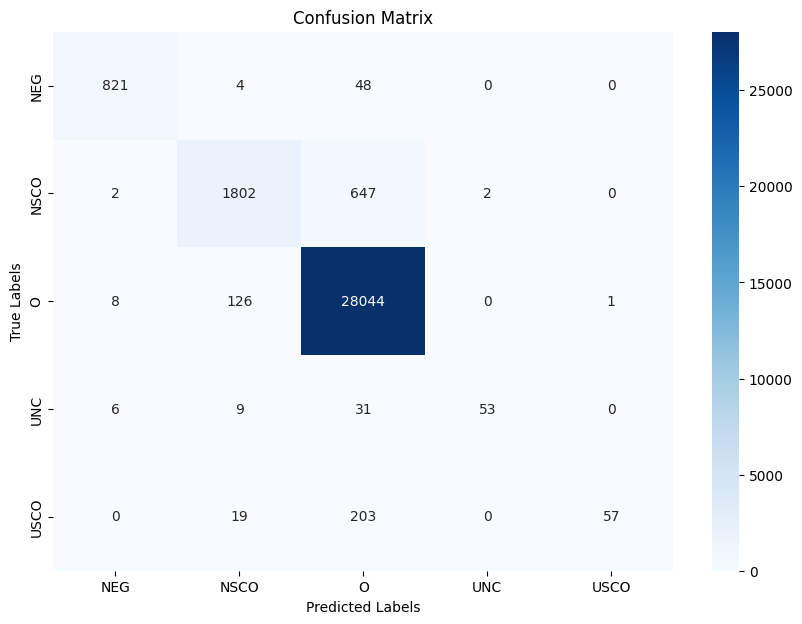

loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 87.85it/s]

Training fold 4/5...


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 83.86it/s]

Fold 4, Iteration 1/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 84.45it/s]

Fold 4, Iteration 2/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 115.86it/s]

Fold 4, Iteration 3/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 85.46it/s] 

Fold 4, Iteration 4/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 100.92it/s]

Fold 4, Iteration 5/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:   8%|▊         | 17/203 [00:00<00:02, 82.37it/s]

Fold 4, Iteration 6/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 93.49it/s] 

Fold 4, Iteration 7/50: Validation Accuracy = 0.8697037772321196


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 90.56it/s]

Fold 4, Iteration 8/50: Validation Accuracy = 0.8704090695365968


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 87.86it/s] 

Fold 4, Iteration 9/50: Validation Accuracy = 0.8699127527297424


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 92.33it/s] 

Fold 4, Iteration 10/50: Validation Accuracy = 0.905072880204796


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 73.49it/s]

Fold 4, Iteration 11/50: Validation Accuracy = 0.9012851993103809


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 105.88it/s]

Fold 4, Iteration 12/50: Validation Accuracy = 0.9252128937882034


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 89.65it/s] 

Fold 4, Iteration 13/50: Validation Accuracy = 0.9251867718510005


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 96.01it/s]

Fold 4, Iteration 14/50: Validation Accuracy = 0.9282169165665326


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 117.22it/s]

Fold 4, Iteration 15/50: Validation Accuracy = 0.9285826236873727


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 84.19it/s]

Fold 4, Iteration 16/50: Validation Accuracy = 0.9330233530118593


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 87.35it/s] 

Fold 4, Iteration 17/50: Validation Accuracy = 0.9345384253696254


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 94.49it/s]

Fold 4, Iteration 18/50: Validation Accuracy = 0.9374379603991432


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 96.19it/s]

Fold 4, Iteration 19/50: Validation Accuracy = 0.9396583250613866


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 79.40it/s]

Fold 4, Iteration 20/50: Validation Accuracy = 0.9411472754819498


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 92.06it/s]

Fold 4, Iteration 21/50: Validation Accuracy = 0.9420092994096442


loading training data to CRFsuite:   5%|▍         | 10/203 [00:00<00:02, 89.28it/s]

Fold 4, Iteration 22/50: Validation Accuracy = 0.9442557860090904


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 92.01it/s] 

Fold 4, Iteration 23/50: Validation Accuracy = 0.9449349563763648


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 102.80it/s]

Fold 4, Iteration 24/50: Validation Accuracy = 0.9472075649130139


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.48it/s]

Fold 4, Iteration 25/50: Validation Accuracy = 0.9415391045399927


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.95it/s]

Fold 4, Iteration 26/50: Validation Accuracy = 0.9492711979520401


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 102.60it/s]

Fold 4, Iteration 27/50: Validation Accuracy = 0.948147954652317


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:01, 92.11it/s]

Fold 4, Iteration 28/50: Validation Accuracy = 0.9514131968026749


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 86.92it/s]

Fold 4, Iteration 29/50: Validation Accuracy = 0.9414607387283841


loading training data to CRFsuite:   8%|▊         | 16/203 [00:00<00:02, 72.30it/s]

Fold 4, Iteration 30/50: Validation Accuracy = 0.9530588788464552


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 81.12it/s]

Fold 4, Iteration 31/50: Validation Accuracy = 0.9536074395277154


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 106.30it/s]

Fold 4, Iteration 32/50: Validation Accuracy = 0.9555665848179301


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:02, 83.26it/s] 

Fold 4, Iteration 33/50: Validation Accuracy = 0.9430802988349616


loading training data to CRFsuite:   5%|▌         | 11/203 [00:00<00:01, 99.09it/s]

Fold 4, Iteration 34/50: Validation Accuracy = 0.9576302178569562


loading training data to CRFsuite:  12%|█▏        | 24/203 [00:00<00:01, 93.28it/s] 

Fold 4, Iteration 35/50: Validation Accuracy = 0.9597983386447939


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 113.96it/s]

Fold 4, Iteration 36/50: Validation Accuracy = 0.9515960503630949


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 79.55it/s]

Fold 4, Iteration 37/50: Validation Accuracy = 0.9574996081709419


loading training data to CRFsuite:  10%|█         | 21/203 [00:00<00:02, 87.88it/s]

Fold 4, Iteration 38/50: Validation Accuracy = 0.9588579489054908


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 114.50it/s]

Fold 4, Iteration 39/50: Validation Accuracy = 0.9575257301081448


loading training data to CRFsuite:   4%|▍         | 9/203 [00:00<00:02, 86.57it/s]

Fold 4, Iteration 40/50: Validation Accuracy = 0.9571861449245076


loading training data to CRFsuite:   6%|▌         | 12/203 [00:00<00:01, 119.24it/s]

Fold 4, Iteration 41/50: Validation Accuracy = 0.9573428765477248


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 87.78it/s] 

Fold 4, Iteration 42/50: Validation Accuracy = 0.9577608275429705


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 86.34it/s] 

Fold 4, Iteration 43/50: Validation Accuracy = 0.9516744161747035


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 81.02it/s]

Fold 4, Iteration 44/50: Validation Accuracy = 0.9556710725667416


loading training data to CRFsuite:  10%|▉         | 20/203 [00:00<00:02, 77.50it/s]

Fold 4, Iteration 45/50: Validation Accuracy = 0.9545478292670184


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 98.21it/s] 

Fold 4, Iteration 46/50: Validation Accuracy = 0.9527454156000209


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:01, 93.31it/s] 

Fold 4, Iteration 47/50: Validation Accuracy = 0.9547045608902356


loading training data to CRFsuite:   9%|▉         | 19/203 [00:00<00:02, 91.15it/s]

Fold 4, Iteration 48/50: Validation Accuracy = 0.9527976594744266


loading training data to CRFsuite:  11%|█         | 22/203 [00:00<00:02, 85.34it/s] 

Fold 4, Iteration 49/50: Validation Accuracy = 0.9539992685857583


loading training data to CRFsuite: 100%|██████████| 203/203 [00:02<00:00, 73.50it/s]


Fold 4, Iteration 50/50: Validation Accuracy = 0.9519356355467321


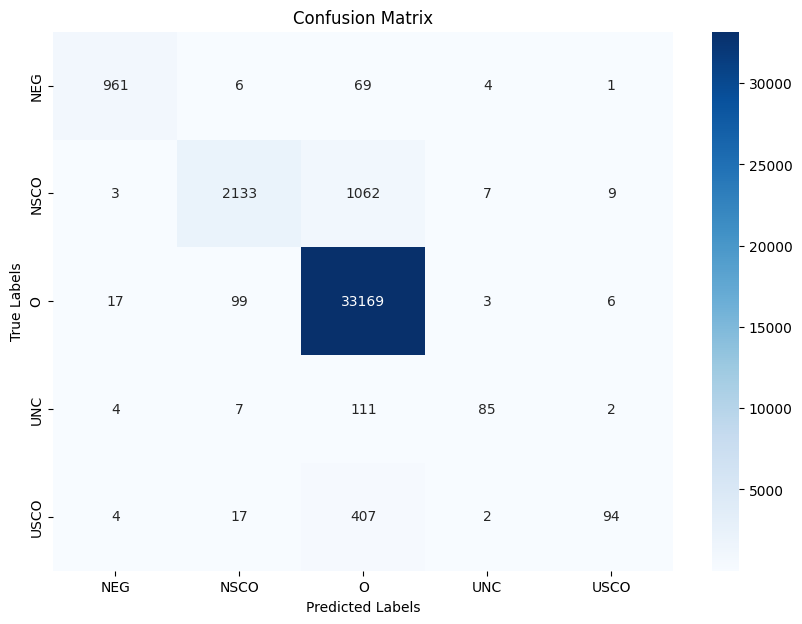

loading training data to CRFsuite:   3%|▎         | 7/204 [00:00<00:02, 68.32it/s]

Training fold 5/5...


loading training data to CRFsuite:  10%|▉         | 20/204 [00:00<00:01, 92.44it/s]

Fold 5, Iteration 1/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  10%|█         | 21/204 [00:00<00:01, 102.70it/s]

Fold 5, Iteration 2/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  10%|█         | 21/204 [00:00<00:01, 94.75it/s]

Fold 5, Iteration 3/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 106.26it/s]

Fold 5, Iteration 4/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 92.38it/s] 

Fold 5, Iteration 5/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 103.94it/s]

Fold 5, Iteration 6/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:   3%|▎         | 7/204 [00:00<00:03, 64.95it/s]

Fold 5, Iteration 7/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:   5%|▍         | 10/204 [00:00<00:02, 83.57it/s]

Fold 5, Iteration 8/50: Validation Accuracy = 0.8873823327722711


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 110.55it/s]

Fold 5, Iteration 9/50: Validation Accuracy = 0.8863537185960975


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 94.78it/s]

Fold 5, Iteration 10/50: Validation Accuracy = 0.9010660183280345


loading training data to CRFsuite:  10%|▉         | 20/204 [00:00<00:02, 90.93it/s]

Fold 5, Iteration 11/50: Validation Accuracy = 0.8905928558069945


loading training data to CRFsuite:  10%|█         | 21/204 [00:00<00:01, 96.80it/s]

Fold 5, Iteration 12/50: Validation Accuracy = 0.9097313135091328


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 107.55it/s]

Fold 5, Iteration 13/50: Validation Accuracy = 0.9057103671840908


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 106.43it/s]

Fold 5, Iteration 14/50: Validation Accuracy = 0.9224798952683748


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 103.44it/s]

Fold 5, Iteration 15/50: Validation Accuracy = 0.9219500031170127


loading training data to CRFsuite:   8%|▊         | 16/204 [00:00<00:02, 72.78it/s]

Fold 5, Iteration 16/50: Validation Accuracy = 0.9284333894395611


loading training data to CRFsuite:  10%|█         | 21/204 [00:00<00:01, 99.49it/s]

Fold 5, Iteration 17/50: Validation Accuracy = 0.9307399788043139


loading training data to CRFsuite:   3%|▎         | 6/204 [00:00<00:04, 45.32it/s]

Fold 5, Iteration 18/50: Validation Accuracy = 0.9323919955115018


loading training data to CRFsuite:   9%|▉         | 19/204 [00:00<00:02, 78.79it/s]

Fold 5, Iteration 19/50: Validation Accuracy = 0.9378155975313259


loading training data to CRFsuite:  10%|█         | 21/204 [00:00<00:01, 102.59it/s]

Fold 5, Iteration 20/50: Validation Accuracy = 0.9341063524717911


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 105.81it/s]

Fold 5, Iteration 21/50: Validation Accuracy = 0.9393117636057602


loading training data to CRFsuite:   5%|▍         | 10/204 [00:00<00:02, 82.70it/s]

Fold 5, Iteration 22/50: Validation Accuracy = 0.9230721276728383


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 110.37it/s]

Fold 5, Iteration 23/50: Validation Accuracy = 0.9423976061342809


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 108.04it/s]

Fold 5, Iteration 24/50: Validation Accuracy = 0.9427093073997881


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 112.03it/s]

Fold 5, Iteration 25/50: Validation Accuracy = 0.9420859048687737


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 110.02it/s]

Fold 5, Iteration 26/50: Validation Accuracy = 0.9454834486628015


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 111.13it/s]

Fold 5, Iteration 27/50: Validation Accuracy = 0.9451717473972945


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 110.24it/s]

Fold 5, Iteration 28/50: Validation Accuracy = 0.9520291752384514


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 113.98it/s]

Fold 5, Iteration 29/50: Validation Accuracy = 0.9531824699208279


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 113.31it/s]

Fold 5, Iteration 30/50: Validation Accuracy = 0.955676080044885


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 113.37it/s]

Fold 5, Iteration 31/50: Validation Accuracy = 0.9569540552334642


loading training data to CRFsuite:   3%|▎         | 7/204 [00:00<00:02, 69.00it/s]

Fold 5, Iteration 32/50: Validation Accuracy = 0.9578891590299856


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:02, 88.40it/s] 

Fold 5, Iteration 33/50: Validation Accuracy = 0.9582320304220435


loading training data to CRFsuite:   5%|▍         | 10/204 [00:00<00:02, 88.92it/s]

Fold 5, Iteration 34/50: Validation Accuracy = 0.9599152172557821


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 102.19it/s]

Fold 5, Iteration 35/50: Validation Accuracy = 0.9598217068761299


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 93.50it/s] 

Fold 5, Iteration 36/50: Validation Accuracy = 0.9613178729505641


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 97.07it/s] 

Fold 5, Iteration 37/50: Validation Accuracy = 0.9641855245932298


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 96.59it/s] 

Fold 5, Iteration 38/50: Validation Accuracy = 0.9609438314319556


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 93.46it/s] 

Fold 5, Iteration 39/50: Validation Accuracy = 0.9630322299108535


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 95.93it/s] 

Fold 5, Iteration 40/50: Validation Accuracy = 0.962751698771897


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 106.09it/s]

Fold 5, Iteration 41/50: Validation Accuracy = 0.9602892587743906


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 106.29it/s]

Fold 5, Iteration 42/50: Validation Accuracy = 0.9617230845957234


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 102.60it/s]

Fold 5, Iteration 43/50: Validation Accuracy = 0.9597281964964778


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 109.26it/s]

Fold 5, Iteration 44/50: Validation Accuracy = 0.9596658562433763


loading training data to CRFsuite:  11%|█▏        | 23/204 [00:00<00:01, 103.37it/s]

Fold 5, Iteration 45/50: Validation Accuracy = 0.9627828688984478


loading training data to CRFsuite:   6%|▌         | 12/204 [00:00<00:01, 110.85it/s]

Fold 5, Iteration 46/50: Validation Accuracy = 0.9596035159902749


loading training data to CRFsuite:  11%|█         | 22/204 [00:00<00:01, 107.14it/s]

Fold 5, Iteration 47/50: Validation Accuracy = 0.9586684121937535


loading training data to CRFsuite:   5%|▌         | 11/204 [00:00<00:01, 105.36it/s]

Fold 5, Iteration 48/50: Validation Accuracy = 0.9609750015585063


loading training data to CRFsuite:  12%|█▏        | 24/204 [00:00<00:01, 106.20it/s]

Fold 5, Iteration 49/50: Validation Accuracy = 0.9590424537123621


loading training data to CRFsuite: 100%|██████████| 204/204 [00:02<00:00, 88.60it/s]


Fold 5, Iteration 50/50: Validation Accuracy = 0.9605697899133471


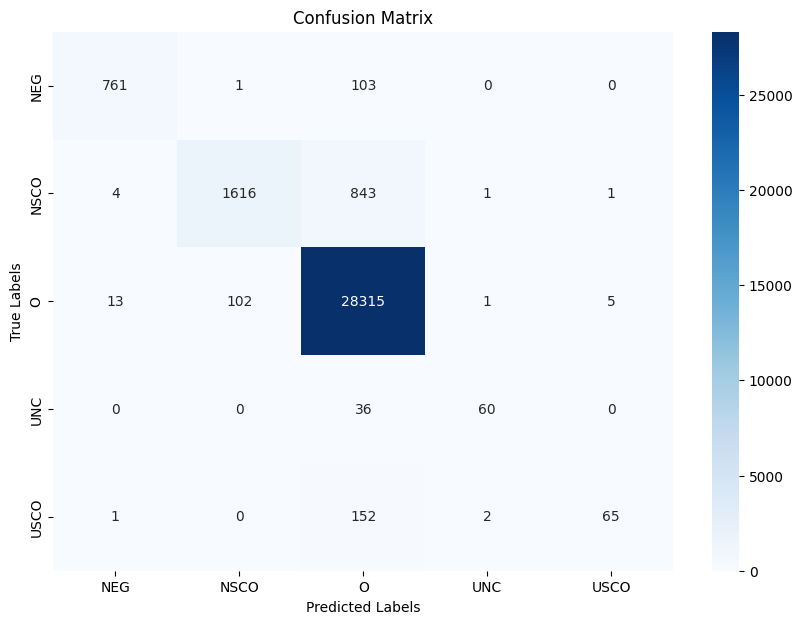

In [21]:
def capture_loss_from_log(log_contents):
    loss_values = [float(match.group(1)) for match in re.finditer(r'loss=(\d+\.\d+)', log_contents)]
    return loss_values

def train_crf_with_cross_validation(X, y, k_folds=5, max_iterations=50):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_loss_values = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}/{k_folds}...")  # Debug print
        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in val_index]
        y_val = [y[i] for i in val_index]

        crf = CRF(
            algorithm='lbfgs',
            c1=0.01, #UPDATED PARAMETERS
            c2=0.01, #UPDATED PARAMETERS
            max_iterations=1, 
            all_possible_transitions=True,
            verbose=True
        )

        val_accuracies = []
        iteration_loss_values = []

        for i in range(1, max_iterations + 1):
            # Capture the log output
            log_stream = StringIO()
            original_stdout = sys.stdout
            sys.stdout = log_stream

            try:
                # Set the number of iterations
                crf.max_iterations = i

                # Fit the model
                crf.fit(X_train, y_train)

            finally:
                sys.stdout = original_stdout

            # Extract loss values
            log_contents = log_stream.getvalue()
            loss_values = capture_loss_from_log(log_contents)
            if loss_values:
                iteration_loss_values.append(loss_values[-1])

            # Evaluate on the validation set
            val_predictions = crf.predict(X_val)
            y_val_flat = list(chain.from_iterable(y_val))
            val_predictions_flat = list(chain.from_iterable(val_predictions))
            val_accuracy = accuracy_score(y_val_flat, val_predictions_flat)

            # Store validation accuracy
            val_accuracies.append(val_accuracy)

            # Print progress
            print(f"Fold {fold + 1}, Iteration {i}/{max_iterations}: Validation Accuracy = {val_accuracy}")

            # Plot confusion matrix for the last iteration of the fold
            if i == max_iterations:
                unique_labels = sorted(set(y_val_flat))
                plot_confusion_matrix(y_val_flat, val_predictions_flat, unique_labels)

        fold_accuracies.append(val_accuracies)
        fold_loss_values.append(iteration_loss_values)

    return fold_accuracies, fold_loss_values

# Perform k-fold cross-validation with validation accuracy and loss tracking
k_folds = 5
max_iterations = 50 #more iterations
fold_accuracies, fold_loss_values = train_crf_with_cross_validation(X_train_full, y_train_full, k_folds, max_iterations)


[0.88527678 0.88527678 0.88527678 0.88527678 0.88527678 0.88527678
 0.88677054 0.88584312 0.88725489 0.90273556 0.90548638 0.9179811
 0.92125894 0.92895651 0.92986483 0.93320997 0.93548368 0.93711739
 0.93964795 0.93999312]


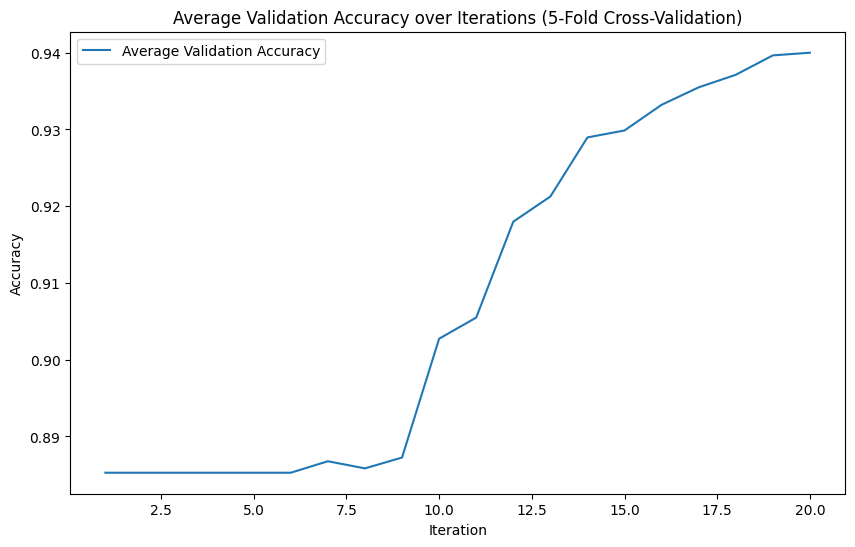

In [18]:
# Calculate average validation accuracy for each iteration
average_accuracies = np.mean(fold_accuracies, axis=0)

# Plot the average validation accuracies over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), average_accuracies, label='Average Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title(f'Average Validation Accuracy over Iterations ({k_folds}-Fold Cross-Validation)')
plt.legend()
plt.show()

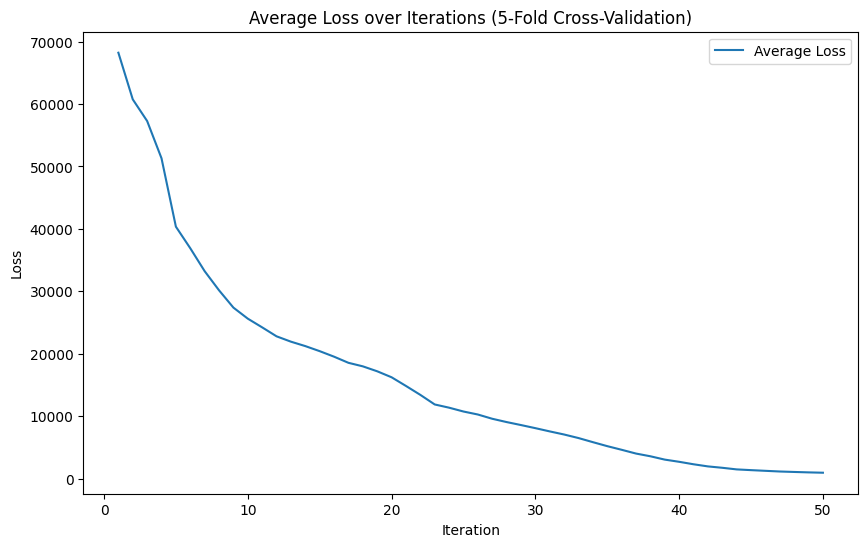

In [23]:
# Calculate average loss for each iteration
average_loss = np.mean(fold_loss_values, axis=0)

# Plot the average loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), average_loss, label='Average Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Average Loss over Iterations ({k_folds}-Fold Cross-Validation)')
plt.legend()
plt.show()


**TEST SET**

In [19]:
def evaluate_crf_on_test_data(test_data, crf_model):
    # Prepare the data for CRF
    X_test, y_test = prepare_data_for_crf(test_data)

    # Use the trained CRF model to predict on the test data
    test_predictions = crf_model.predict(X_test)

    # Flatten the label sequences for the test set
    y_test_flat = list(chain.from_iterable(y_test))
    predictions_flat = list(chain.from_iterable(test_predictions))

    # Calculate the accuracy
    test_accuracy = accuracy_score(y_test_flat, predictions_flat)
    unique_labels = sorted(set(y_test_flat))

    report = classification_report(y_test_flat, predictions_flat, output_dict=True)

    plot_confusion_matrix(y_test_flat, predictions_flat, unique_labels)

    return test_accuracy, predictions_flat , report

In [16]:
# Loading the TEST json file
loading = open("negacio_test_v2024.json")
test_data = json.load(loading)
print(len(training_data))

254


In [17]:
# choosed model parameters
crf = CRF(
            algorithm='lbfgs',
            c1=0.01,
            c2=0.01,
            max_iterations=50,
            all_possible_transitions=True,
            verbose=True
        )

loading training data to CRFsuite: 100%|██████████| 254/254 [00:02<00:00, 85.56it/s] 



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 243811
Seconds required: 0.863

L-BFGS optimization
c1: 0.010000
c2: 0.010000
num_memories: 6
max_iterations: 50
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.43  loss=85291.43 active=243290 feature_norm=1.00
Iter 2   time=0.22  loss=75954.89 active=239717 feature_norm=1.23
Iter 3   time=0.23  loss=71692.25 active=241133 feature_norm=1.34
Iter 4   time=0.23  loss=65372.06 active=241004 feature_norm=1.77
Iter 5   time=0.22  loss=52068.70 active=242909 feature_norm=2.08
Iter 6   time=0.74  loss=49232.38 active=243316 feature_norm=2.48
Iter 7   time=0.26  loss=43661.52 active=243411 feature_norm=2.83
Iter 8   time=0.24  loss=39736.58 active=243534 feature_norm=3.28
Iter 9   time=0.20  loss=36218.62 active=243563 feature_norm=3.56
Iter 

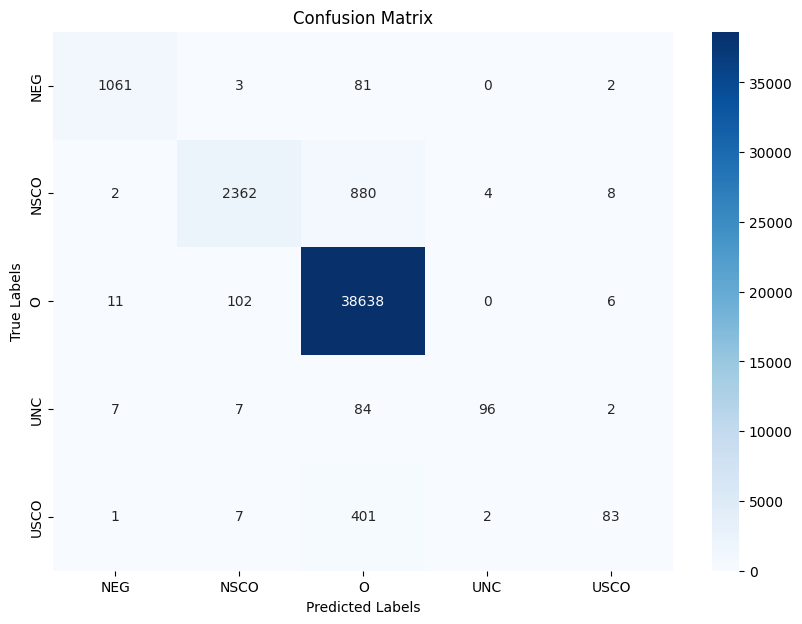

In [44]:
crf.fit(X_train_full, y_train_full)
test_accuracy ,predictions_flat, report = evaluate_crf_on_test_data(test_data, crf)

In [45]:
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9632839224629418


In [47]:
print(pd.DataFrame(report).transpose())

              precision    recall  f1-score       support
NEG            0.980591  0.925022  0.951996   1147.000000
NSCO           0.952035  0.725430  0.823427   3256.000000
O              0.963926  0.996930  0.980150  38757.000000
UNC            0.941176  0.489796  0.644295    196.000000
USCO           0.821782  0.168016  0.278992    494.000000
accuracy       0.963284  0.963284  0.963284      0.963284
macro avg      0.931902  0.661039  0.735772  43850.000000
weighted avg   0.961776  0.963284  0.958376  43850.000000
